In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
from collections import defaultdict
import logging
import sys
import time

# SET LOGGER
logger = logging.getLogger("root")
logger.setLevel(logging.DEBUG)
# create console handler
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)

# ESTABLISH A DIRECTORY PATH
PATH = '/Users/amir/code/joe/OMOP_Hospital_Predict/Joe_results/'

#How to create a control dataset!

#we need the following 5 dataframes
#1: Hosp: inpatient: 9201, condition: ICDM codes, Primary and secondary, visit_date< 2018, from Mdd and stagging
#2: Diagnosis: visit_concept: !9201--diagnose, condition: ICDM codes, Primary and secondary, visit_date< 2018, from Mdd and stagging, diagnosis date..., from condition occurence and visit occurence
#3: Visits: from stagging and MDD and time 2012, 2017... 

# IMPORT DATA
hosp = pd.read_csv(PATH+'cdrn_psych_hosp_bef_18.csv', encoding='utf-8', names=['person_id', 'inpt_hosp_date', 'visit_occurrence_id', 'visit_concept_id', 'condition_type_concept_id'],delimiter="\t") # cdrn_psych_primary_hosp_bef_18.csv
diagnosis = pd.read_csv(PATH+'cdrn_psych_dx_bef_18.csv', encoding='utf-8', names=['person_id', 'psych_dx_date'],delimiter="\t")
visits = pd.read_csv(PATH+'cdrn_all_visits_1218.csv', encoding='utf-8', names=['person_id', 'visit_occurrence_id', 'visit_start_date', 'visit_concept_id'],delimiter="\t")
no_hosp = pd.read_csv(PATH+'cdrn_no_psych_hosp_bef_18.csv', encoding='utf-8', names=['person_id', 'condition_start_date', 'condition_source_value'],delimiter="\t")
demographics = pd.read_csv(PATH+'cdrn_pt_demographics.csv', encoding='utf-8', names=['person_id', 'gender_concept_id', 'birth_date'],delimiter="\t")




In [89]:
#Health care Utilization 

visits['visit_concept_id'].value_counts()
visits['visit_concept_id_cat']= visits['visit_concept_id'].apply(lambda x: "Outpatient Visit" if float(x) == 9202 else ("Ambulatory visit" if float(x) == 44814711 else( "Inpatient Visit" if float(x) == 9201 else( "Emergency Room Visit" if float(x) == 9203 else( "Other" if float(x) == 44814649  else "NA")))))
                                                                                                                                                                 # •	Inpatient Visit:  9201 
# •	Outpatient Visit:  9202 
# •	Emergency Room Visit:  9203 
# •	Long Term Care Visit:  42898160 
# plus the following concepts from vocabulary_id  =  ‘PCORnet’:
# •	Non-Acute Institutional Stay: 44814710
# •	Other ambulatory visit: 44814711
# •	No Information:   44814650 
# •	Unknown:   44814653 
# •	Other:   44814649 


In [90]:
visits['visit_concept_id_cat'].value_counts()

Outpatient Visit        20829833
Other                    8247354
Emergency Room Visit     1934272
Ambulatory visit         1127255
Inpatient Visit           648525
NA                          1721
Name: visit_concept_id_cat, dtype: int64

In [91]:
visits['visit_concept_id'].value_counts()

9202        20829833
44814649     8247354
9203         1934272
44814711     1127255
9201          648525
0               1721
Name: visit_concept_id, dtype: int64

In [105]:
from datetime import datetime
from dateutil.parser import parse
import pandas as pd

visits['visit_concept_id']
# train_data.groupby('visit_start_date').count()
visits['visit_start_date']= pd.to_datetime(visits['visit_start_date'])

visits.index=visits['visit_start_date']
visits.index.month

series =  visits.groupby(pd.Grouper(freq='M')).count()[['visit_concept_id_cat']]
#train_data['condition_source_value'].value_counts()
series.head(5)



,visit_concept_id_cat
visit_start_date,
2012-01-31,406196
2012-02-29,397728
2012-03-31,436031
2012-04-30,412377
2012-05-31,437213


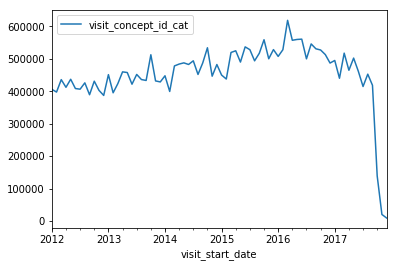

In [93]:
from pandas import Series
from matplotlib import pyplot
series.plot()
pyplot.show()

In [101]:
series = visits.groupby([pd.Grouper(key='visit_start_date', freq='M'),'visit_concept_id_cat'])['visit_occurrence_id'].count()
series

visit_start_date  visit_concept_id_cat
2012-01-31        Ambulatory visit          9501
                  Emergency Room Visit     27796
                  Inpatient Visit          10157
                  NA                          25
                  Other                    90045
                  Outpatient Visit        268672
2012-02-29        Ambulatory visit          9268
                  Emergency Room Visit     25979
                  Inpatient Visit           9596
                  NA                          21
                  Other                    87322
                  Outpatient Visit        265542
2012-03-31        Ambulatory visit         10262
                  Emergency Room Visit     28266
                  Inpatient Visit          10278
                  NA                          26
                  Other                    94062
                  Outpatient Visit        293137
2012-04-30        Ambulatory visit          9906
                  Emergency Ro

In [103]:
series2 = series.reset_index()
series2.head(5)
# series['visit_start_date'] = pd.to_datetime(series['visit_start_date'])
# series.head(5)

,visit_start_date,visit_concept_id_cat,visit_occurrence_id
0,2012-01-31,Ambulatory visit,9501
1,2012-01-31,Emergency Room Visit,27796
2,2012-01-31,Inpatient Visit,10157
3,2012-01-31,NA,25
4,2012-01-31,Other,90045


In [104]:
series2.to_csv("/Users/amir/code/Hospitalization_Weill_cornell/Healthcare_utilization_freq_time_sereies.tsv", sep='\t')


In [2]:
no_hosp.head(5)
#

,person_id,condition_start_date,condition_source_value
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-11,ICD9CM:311
1,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311
2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2012-07-30,ICD9CM:311
3,00027da2-9778-af1a-e029-b22ea45d7efc,2016-08-12,ICD10CM:F32.9
4,00027da2-9778-af1a-e029-b22ea45d7efc,2016-08-30,ICD10CM:F32.9


In [107]:
x = no_hosp
# select 1 random visit (w/ psych dx) from each patient
control = x.groupby('person_id').apply(lambda y: y.sample(n=1, random_state=1).reset_index(drop=True))
control.head(5)

,,person_id,condition_start_date,condition_source_value
person_id,,,,
00007e76-7d3c-c95f-dc3b-8245c0c22db0,0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-11,ICD9CM:311
00009027-53e7-284f-9ae3-669c8fe87c80,0,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311
000200cf-29d8-0b8c-0e18-6abdb7a15d5e,0,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2012-07-30,ICD9CM:311
00027da2-9778-af1a-e029-b22ea45d7efc,0,00027da2-9778-af1a-e029-b22ea45d7efc,2016-08-12,ICD10CM:F32.9
00029eb3-9beb-7276-f165-c1aec0809be9,0,00029eb3-9beb-7276-f165-c1aec0809be9,2017-02-06,ICD9CM:311


In [5]:

control = control.reset_index(drop=True)
control['condition_start_date'] = pd.to_datetime(control['condition_start_date'])
control.head(5)

,person_id,condition_start_date,condition_source_value
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-11,ICD9CM:311
1,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311
2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2012-07-30,ICD9CM:311
3,00027da2-9778-af1a-e029-b22ea45d7efc,2016-08-12,ICD10CM:F32.9
4,00029eb3-9beb-7276-f165-c1aec0809be9,2017-02-06,ICD9CM:311


In [106]:
# establish index date based on psych dx date
# create a window based on the condition of each patient
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
from collections import defaultdict
import logging
import sys
import time

dates = {"visit_win_start":[],"visit_win_end":[]}
for _ in control['condition_start_date']:
#     print (_)
#     print (dt.datetime(2013,1,1,00,00,00))
    if _ < dt.datetime(2013,1,1,00,00,00): #2013-01-01 00:00:00
        delta = (dt.datetime(2013, 1, 1, 00, 00, 00) - _).days
#         print (delta)
#         raise KeyboardInterrupt
        
        if delta == 366:
            d2 = dt.datetime(2013, 1, 1, 00, 00, 00)
            d1 = d2 - dt.timedelta(366)
            dates["visit_win_end"].append(d2)
            dates["visit_win_start"].append(d1)
        else:
            random = np.random.randint(delta, 366)
            d2 = _ + np.timedelta64(random,'D')
            d1 = d2 - np.timedelta64(366, 'D')
            dates["visit_win_end"].append(d2)
            dates["visit_win_start"].append(d1)
    elif dt.datetime(2013,1,1,00,00,00) <= _ <= dt.datetime(2016,12,31,00,00,00):
        random = np.random.randint(0, 366)
        d2 = _ + np.timedelta64(random, 'D')
        d1 = d2 - np.timedelta64(366, 'D')
        dates["visit_win_end"].append(d2)
        dates["visit_win_start"].append(d1)
    else:
        delta = (dt.datetime(2017, 12, 31, 00, 00, 00) - _).days # update to 12.31.2017 with larger sample size
        if delta == 0:
            d2 = _
            d1 = d2 - np.timedelta64(366, 'D')
            dates["visit_win_end"].append(d2)
            dates["visit_win_start"].append(d1)
        else:
            random = np.random.randint(0, delta)
            d2 = _ + np.timedelta64(random, 'D')
            d1 = d2 - np.timedelta64(366, 'D')
            dates["visit_win_end"].append(d2)
            dates["visit_win_start"].append(d1)

window = pd.DataFrame(dates)
window.head(5)


,visit_win_start,visit_win_end
0,2014-08-27,2015-08-28
1,2013-03-20,2014-03-21
2,2012-06-04,2013-06-05
3,2015-10-04,2016-10-04
4,2016-12-06,2017-12-07


In [7]:
control_2 = pd.merge(control, window, left_index=True, right_index=True)
control_2.head(5)

,person_id,condition_start_date,condition_source_value,visit_win_start,visit_win_end
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-11,ICD9CM:311,2013-11-13,2014-11-14
1,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311,2013-10-12,2014-10-13
2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2012-07-30,ICD9CM:311,2012-06-18,2013-06-19
3,00027da2-9778-af1a-e029-b22ea45d7efc,2016-08-12,ICD10CM:F32.9,2015-11-01,2016-11-01
4,00029eb3-9beb-7276-f165-c1aec0809be9,2017-02-06,ICD9CM:311,2016-10-25,2017-10-26


In [126]:
#we merged the condition table and visit table
#select only those users who have visit in between the window time

z = visits
control_3 = control_2.merge(z, on='person_id', how='left')
control_3 = control_3.sort_values(by=['person_id', 'visit_win_end'])
control_3['visit_start_date'] = pd.to_datetime(control_3['visit_start_date'])
control_3 = control_3[(control_3.visit_start_date >= control_3.visit_win_start) & (control_3.visit_start_date < control_3.visit_win_end)]

control_3.head(5)


,person_id,condition_start_date,condition_source_value,visit_win_start,visit_win_end,visit_occurrence_id,visit_start_date,visit_concept_id,visit_concept_id_cat
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-11,ICD9CM:311,2013-11-13,2014-11-14,20858134,2014-11-13,9202,Outpatient Visit
1,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-11,ICD9CM:311,2013-11-13,2014-11-14,20858228,2014-11-11,9203,Emergency Room Visit
16,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311,2013-10-12,2014-10-13,13290983,2014-09-16,9202,Outpatient Visit
27,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311,2013-10-12,2014-10-13,84035168,2014-02-06,9202,Outpatient Visit
28,00009027-53e7-284f-9ae3-669c8fe87c80,2014-02-06,ICD9CM:311,2013-10-12,2014-10-13,80705491,2014-01-27,9202,Outpatient Visit


In [129]:

# control_3_hospitalizd = control_3.loc[control_3['visit_concept_id'] == '9201']   
control_3  = control_3[control_3.visit_concept_id == '9201']
control_3.describe

<bound method NDFrame.describe of Empty DataFrame
Columns: [person_id, condition_start_date, condition_source_value, visit_win_start, visit_win_end, visit_occurrence_id, visit_start_date, visit_concept_id, visit_concept_id_cat]
Index: []>

In [9]:
# control_3.describe()
control_3.describe(include='all')

,person_id,condition_start_date,condition_source_value,visit_win_start,visit_win_end,visit_occurrence_id,visit_start_date,visit_concept_id
count,1828273,1828273,1828273,1828273,1828273,1.828273e+06,1828273,1.828273e+06
unique,113774,2133,177,1825,1825,NaN,2171,NaN
top,cff2900c-53b9-c935-0450-50f7b82b9530,2017-09-20 00:00:00,ICD9CM:311,2012-01-01 00:00:00,2013-01-01 00:00:00,NaN,2017-01-17 00:00:00,NaN
freq,1657,3515,932782,4695,4695,NaN,2442,NaN
first,NaN,2012-01-01 00:00:00,NaN,2012-01-01 00:00:00,2013-01-01 00:00:00,NaN,2012-01-01 00:00:00,NaN
last,NaN,2017-11-02 00:00:00,NaN,2016-12-29 00:00:00,2017-12-30 00:00:00,NaN,2017-12-27 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.355539e+08,NaN,2.195214e+07
std,NaN,NaN,NaN,NaN,NaN,1.223452e+08,NaN,2.239802e+07
min,NaN,NaN,NaN,NaN,NaN,8.080000e+02,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,5.110129e+07,NaN,9.202000e+03


In [17]:
control_4 = control_3.groupby('person_id').visit_start_date.agg(['first', 'last'])
control_4.head(5)


,first,last
person_id,,
00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-13,2014-11-11
00009027-53e7-284f-9ae3-669c8fe87c80,2014-09-16,2014-01-27
000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2013-05-09,2013-01-03
00027da2-9778-af1a-e029-b22ea45d7efc,2016-06-07,2016-07-12
00029eb3-9beb-7276-f165-c1aec0809be9,2016-12-06,2017-02-28


In [122]:
# control_test = control_3.groupby('person_id')['visit_concept_id' ==]
# #.visit_start_date.agg(['first', 'last'])[['visit_concept_id_cat']]
# control_test.head(5)

# visits.groupby(pd.Grouper(freq='M')).count()[['visit_concept_id_cat']]

In [19]:
# CALCULATE DAYS BETWEEN X-Y
def days_between(d1, d2):
    d1 = datetime.strptime(d1, '%Y-%m-%d')
    d2 = datetime.strptime(d2, '%Y-%m-%d')
    return abs((d2 - d1).days)


control_4 = control_4.reset_index()
first_last = {"first":[], "last":[]}
for i in control_4['first']:
    
    date1 = pd.to_datetime(i)
    #print (date1)
    date2 = date1.date()
    #print (date2)
    first_last["first"].append(date2)
    #print (first_last["first"].append(date2))
    #raise KeyboardInterrupt
for i in control_4['last']:
    date1 = pd.to_datetime(i)
    date2 = date1.date()
    first_last["last"].append(date2)
first_last = pd.DataFrame(first_last)
control_4_ = pd.merge(control_4, first_last, left_index=True, right_index=True)
control_4_['date_diff'] = control_4_.apply(lambda row: days_between(str(row['first_y']), str(row['last_y'])), axis=1)



In [21]:
control_4_['date_diff'].head(5)


0      2
1    232
2    126
3     35
4     84
Name: date_diff, dtype: int64

In [120]:
control_4_.head(5)

,index,person_id,first_x,last_x,first_y,last_y,date_diff
0,0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-13,2014-11-11,2014-11-13,2014-11-11,2
1,1,00009027-53e7-284f-9ae3-669c8fe87c80,2014-09-16,2014-01-27,2014-09-16,2014-01-27,232
2,2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2013-05-09,2013-01-03,2013-05-09,2013-01-03,126
3,3,00027da2-9778-af1a-e029-b22ea45d7efc,2016-06-07,2016-07-12,2016-06-07,2016-07-12,35
4,4,00029eb3-9beb-7276-f165-c1aec0809be9,2016-12-06,2017-02-28,2016-12-06,2017-02-28,84


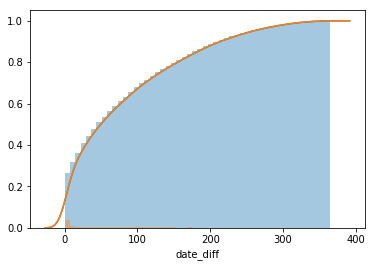

In [119]:
# sns.distplot(control_v['visit_count'][:100]);
sns.distplot(control_4_['date_diff'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

# sns.distplot(control_4_['date_diff'],
#              kde_kws=dict(cumulative=True))

In [24]:
control_v = control_3.groupby('person_id').visit_occurrence_id.agg('count')
control_v.head(5)
control_v = control_v.reset_index()

control_v.rename(columns={'visit_occurrence_id': 'visit_count'}, inplace=True)
control_v.head(5)

,person_id,visit_count
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2
1,00009027-53e7-284f-9ae3-669c8fe87c80,3
2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,26
3,00027da2-9778-af1a-e029-b22ea45d7efc,11
4,00029eb3-9beb-7276-f165-c1aec0809be9,66


In [114]:
control_v.sort_values(by=['visit_count'],ascending=False)[:10]
#control_v.sort_values(by=['visit_count'],ascending=False)[:10]





,person_id,visit_count
92321,cff2900c-53b9-c935-0450-50f7b82b9530,1657
68962,9b516b4f-6711-0b3f-ad96-5b678ce34215,1535
70734,9f50686d-364b-e7f3-25ed-53e6517f5a29,1408
30913,45a6c4a9-543e-6e09-86bd-6f42260f7b89,1326
49950,709311e8-3e05-792e-71cc-85e174a7e795,1188
31959,480cdb8a-6aca-e94c-e8e9-c279b66ee47a,1135
4526,0a396da1-3b40-4603-1093-bd12ffe2b6a7,1133
62728,8d56cbe6-b896-f30c-e952-7f58a7b49b0f,913
49813,704ecc5b-0720-7a72-7cae-2f1d0c3b9524,904
4231,0991fd4d-4f54-5e02-664c-f4276b4c7f7b,872


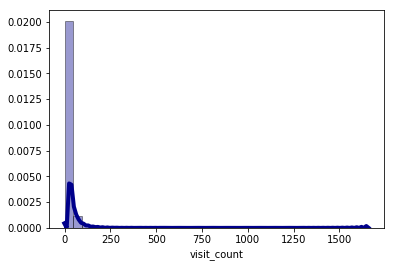

In [115]:
# control_v.sort_values(by=['visit_count'],ascending=False)[:1000]
import seaborn as sns
# Density Plot and Histogram of all occurrence visit_occurrence_id 
sns.distplot(control_v['visit_count'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [116]:
control_v.sort_values(by=['visit_count'],ascending=False)[:10]

,person_id,visit_count
92321,cff2900c-53b9-c935-0450-50f7b82b9530,1657
68962,9b516b4f-6711-0b3f-ad96-5b678ce34215,1535
70734,9f50686d-364b-e7f3-25ed-53e6517f5a29,1408
30913,45a6c4a9-543e-6e09-86bd-6f42260f7b89,1326
49950,709311e8-3e05-792e-71cc-85e174a7e795,1188
31959,480cdb8a-6aca-e94c-e8e9-c279b66ee47a,1135
4526,0a396da1-3b40-4603-1093-bd12ffe2b6a7,1133
62728,8d56cbe6-b896-f30c-e952-7f58a7b49b0f,913
49813,704ecc5b-0720-7a72-7cae-2f1d0c3b9524,904
4231,0991fd4d-4f54-5e02-664c-f4276b4c7f7b,872


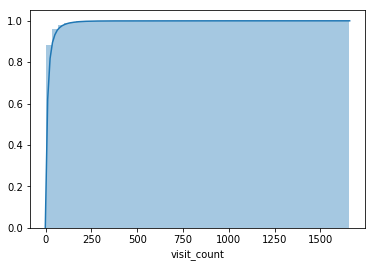

In [117]:
# sns.distplot(control_v['visit_count'][:100]);
sns.distplot(control_v['visit_count'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [58]:
#control_v['visit_count'][:1000]
control_v_sorted= control_v.sort_values(['visit_count'], ascending=False)[:1000]

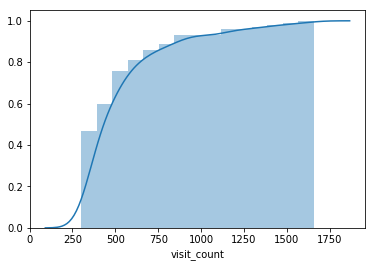

In [61]:
# sns.distplot(control_v['visit_count'][:100]);
sns.distplot(control_v_sorted['visit_count'][:100],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [ ]:
#it seems good for conducting readmission experiments and time series for each user

In [62]:
control_5 = control_4_.merge(control_2, on='person_id', how='left')
control_5 = control_5.merge(control_v, on='person_id', how='left')
control_5.rename(columns={'visit_win_end': 'index_date', 'visit_win_start':'one_year_date'}, inplace=True)
control_5.head(5)

,index,person_id,first_x,last_x,first_y,last_y,date_diff,condition_start_date,condition_source_value,one_year_date,index_date,visit_count
0,0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-13,2014-11-11,2014-11-13,2014-11-11,2,2014-11-11,ICD9CM:311,2013-11-13,2014-11-14,2
1,1,00009027-53e7-284f-9ae3-669c8fe87c80,2014-09-16,2014-01-27,2014-09-16,2014-01-27,232,2014-02-06,ICD9CM:311,2013-10-12,2014-10-13,3
2,2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2013-05-09,2013-01-03,2013-05-09,2013-01-03,126,2012-07-30,ICD9CM:311,2012-06-18,2013-06-19,26
3,3,00027da2-9778-af1a-e029-b22ea45d7efc,2016-06-07,2016-07-12,2016-06-07,2016-07-12,35,2016-08-12,ICD10CM:F32.9,2015-11-01,2016-11-01,11
4,4,00029eb3-9beb-7276-f165-c1aec0809be9,2016-12-06,2017-02-28,2016-12-06,2017-02-28,84,2017-02-06,ICD9CM:311,2016-10-25,2017-10-26,66


In [70]:
w = demographics
control_6 = control_5.merge(w, on='person_id', how='inner')
control_6['age'] = control_6.apply(lambda row: round((days_between(str(row['last_y']), str(row['birth_date'])) / 365)),
                                   axis=1)
control_6.head(5)



,index,person_id,first_x,last_x,first_y,last_y,date_diff,condition_start_date,condition_source_value,one_year_date,index_date,visit_count,gender_concept_id,birth_date,age
0,0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,2014-11-13,2014-11-11,2014-11-13,2014-11-11,2,2014-11-11,ICD9CM:311,2013-11-13,2014-11-14,2,8507,1994-12-26,20
1,1,00009027-53e7-284f-9ae3-669c8fe87c80,2014-09-16,2014-01-27,2014-09-16,2014-01-27,232,2014-02-06,ICD9CM:311,2013-10-12,2014-10-13,3,8507,1969-08-09,44
2,2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,2013-05-09,2013-01-03,2013-05-09,2013-01-03,126,2012-07-30,ICD9CM:311,2012-06-18,2013-06-19,26,8532,1931-08-03,81
3,3,00027da2-9778-af1a-e029-b22ea45d7efc,2016-06-07,2016-07-12,2016-06-07,2016-07-12,35,2016-08-12,ICD10CM:F32.9,2015-11-01,2016-11-01,11,8532,1987-08-01,29
4,4,00029eb3-9beb-7276-f165-c1aec0809be9,2016-12-06,2017-02-28,2016-12-06,2017-02-28,84,2017-02-06,ICD9CM:311,2016-10-25,2017-10-26,66,8532,1942-08-16,75


In [72]:
control_6['Gender']= control_6['gender_concept_id'].apply(lambda x: "Female" if float(x) == 8532 else ("Male" if float(x) == 8507 else "NA"))
#control_6['gender_concept_id'].describe()

In [75]:
control_6['Gender'].value_counts()
# train_data['condition_source_value']

# 

Female    74947
Male      38826
NA            1
Name: Gender, dtype: int64

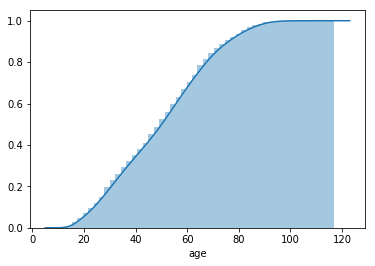

In [76]:
# sns.distplot(control_v['visit_count'][:100]);
sns.distplot(control_6['age'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [81]:

control_6.sort_values(by=['age'],ascending=False)[:1000]
# we have age 11 !!!!!!
#Really age 117!!!

,index,person_id,first_x,last_x,first_y,last_y,date_diff,condition_start_date,condition_source_value,one_year_date,index_date,visit_count,gender_concept_id,birth_date,age,Gender
46184,46184,68249f33-3091-0f88-c0ac-e84fe57799b5,2016-07-17,2016-07-17,2016-07-17,2016-07-17,0,2016-07-17,ICD9CM:298.9,2016-04-29,2017-04-30,1,8507,1900-01-01,117,Male
21055,21055,2fb2456d-f671-ca68-2bd2-55d4605db76e,2013-09-26,2013-06-10,2013-09-26,2013-06-10,108,2013-08-22,ICD9CM:311,2013-05-11,2014-05-12,14,8532,1905-07-06,108,Female
77925,77925,af9c09f0-e19a-1665-21ac-e7365cd9bf7c,2016-04-13,2015-07-09,2016-04-13,2015-07-09,279,2016-04-15,ICD10CM:F32.9,2015-06-27,2016-06-27,6,8532,1909-06-26,106,Female
39123,39123,5813fd04-b308-fbb1-fb1b-ceec57fefe48,2013-04-19,2013-08-30,2013-04-19,2013-08-30,133,2013-02-22,ICD9CM:311,2012-12-24,2013-12-25,5,8532,1908-05-06,105,Female
18405,18405,29e847f3-c361-5c62-0dde-a16717929840,2015-08-25,2016-05-19,2015-08-25,2016-05-19,268,2015-11-23,ICD10CM:F32.9,2015-08-06,2016-08-06,12,8532,1911-02-01,105,Female
33013,33013,4a5f0b97-263f-2b4a-5804-70be18cf29e8,2016-10-14,2016-10-11,2016-10-14,2016-10-11,3,2016-10-14,ICD9CM:311,2016-06-07,2017-06-08,4,8532,1912-06-05,104,Female
10175,10175,17455500-c360-fdc1-7692-24248c7e0951,2012-12-11,2012-06-26,2012-12-11,2012-06-26,168,2012-04-02,ICD9CM:311,2012-03-07,2013-03-08,19,8532,1908-10-09,104,Female
77398,77398,ae684cba-0508-f762-ae0e-1580881563a9,2013-02-25,2013-09-13,2013-02-25,2013-09-13,200,2013-12-13,ICD9CM:311,2013-02-09,2014-02-10,7,8532,1909-07-15,104,Female
64779,64779,91d6b5d7-aed8-bfc8-6bf4-440353232c05,2013-07-10,2012-12-20,2013-07-10,2012-12-20,202,2013-04-11,ICD9CM:311,2012-12-09,2013-12-10,5,8532,1910-01-01,103,Female
7327,7327,10b2e262-11d2-7ca0-7769-b8fcf340e60d,2014-06-30,2014-06-30,2014-06-30,2014-06-30,0,2014-02-10,ICD9CM:298.9,2014-01-14,2015-01-15,43,8532,1911-10-14,103,Female


In [ ]:
#fraction of visit type vs time from last visit
#avg duration day, 
control_6

In [82]:
#'visit_win_end': 'index_date'

#'visit_win_start':'one_year_date'

features = ['person_id', 'age', 'gender_concept_id', 'index_date', 'one_year_date', 'date_diff', 'visit_count']
control_6 = control_6.loc[:,features]
control_6['enc'] = 99
print("Number of controls: {}".format(len(control_6)))


Number of controls: 113774


In [130]:
control_6.head(5)

,person_id,age,gender_concept_id,index_date,one_year_date,date_diff,visit_count,enc
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,20,8507,2014-11-14,2013-11-13,2,2,99
1,00009027-53e7-284f-9ae3-669c8fe87c80,44,8507,2014-10-13,2013-10-12,232,3,99
2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,81,8532,2013-06-19,2012-06-18,126,26,99
3,00027da2-9778-af1a-e029-b22ea45d7efc,29,8532,2016-11-01,2015-11-01,35,11,99
4,00029eb3-9beb-7276-f165-c1aec0809be9,75,8532,2017-10-26,2016-10-25,84,66,99


In [131]:
#------------Finding cases----------------
# w, x, y, z
# demographics, hosp, diagnosis, visits

# demographics
# hosp
# diagnosis
# visits
# !!!no_hosp

w = demographics
x = hosp
y = diagnosis 
z = visits


In [132]:
x.head(5)
# we can see inpt_hosp_date is created in hospitalization dataframe, and it is infact visit_start_date for those who were inpatient 
#hosp = pd.read_csv(PATH+'cdrn_psych_hosp_bef_18.csv', encoding='utf-8', names=['person_id', 'inpt_hosp_date', 'visit_occurrence_id', 'visit_concept_id', 'condition_type_concept_id'],delimiter="\t") # cdrn_psych_primary_hosp_bef_18.csv

,person_id,inpt_hosp_date,visit_occurrence_id,visit_concept_id,condition_type_concept_id
0,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629
1,0000065b-70b3-50d4-4288-822806b2703b,2015-04-09,109179361,9201,44786629
2,0000065b-70b3-50d4-4288-822806b2703b,2015-05-06,74095278,9201,44786629
3,0000065b-70b3-50d4-4288-822806b2703b,2015-06-15,72982855,9201,44786629
4,00005755-7cf9-f71a-0da4-008d581bdcc9,2016-02-08,72577235,9201,44786629


In [133]:
# Creates var 'hosp_num': successive count of psych hosp per 'person_id' (ascending order by date)
# Identifies the first psych hospitalization, but is not necessarily the first psych hosp ever
x['hosp_num'] = x.groupby('person_id').inpt_hosp_date.apply(pd.Series.rank)

In [134]:
x.head(5)


,person_id,inpt_hosp_date,visit_occurrence_id,visit_concept_id,condition_type_concept_id,hosp_num
0,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629,1.0
1,0000065b-70b3-50d4-4288-822806b2703b,2015-04-09,109179361,9201,44786629,2.0
2,0000065b-70b3-50d4-4288-822806b2703b,2015-05-06,74095278,9201,44786629,3.0
3,0000065b-70b3-50d4-4288-822806b2703b,2015-06-15,72982855,9201,44786629,4.0
4,00005755-7cf9-f71a-0da4-008d581bdcc9,2016-02-08,72577235,9201,44786629,1.0


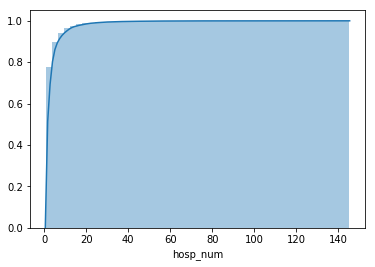

In [135]:
#CDF for hospilization number 
sns.distplot(x['hosp_num'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [136]:
#descriptive statistics for psych hosp per person
x['hosp_num'].describe()

count    197100.000000
mean          3.181284
std           5.109217
min           1.000000
25%           1.000000
50%           1.500000
75%           3.000000
max         145.000000
Name: hosp_num, dtype: float64

In [144]:
#data is scewed... what is the median?
x['hosp_num'].median()

1.5

In [ ]:
#time series!!!

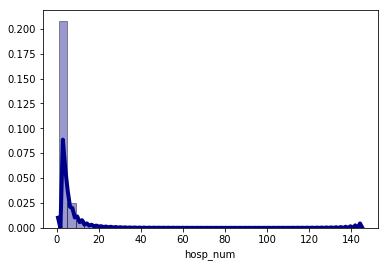

In [137]:
#distribution of Number of hospitalization for those who expeinced psych_hosp_bef_18
sns.distplot(x['hosp_num'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [142]:
x.sort_values(by=['hosp_num'],ascending=False)[:10]

,person_id,inpt_hosp_date,visit_occurrence_id,visit_concept_id,condition_type_concept_id,hosp_num
128538,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-11-27,348597708,9201,44786629,145.0
128537,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-11-21,348641600,9201,44786629,144.0
128536,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-11-13,348616988,9201,44786629,143.0
128535,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-10-31,349073799,9201,44786629,142.0
128534,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-10-21,349388985,9201,44786629,141.0
128533,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-10-17,348490369,9201,44786629,140.0
128532,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-10-10,349536615,9201,44786629,139.0
128531,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-10-02,348581471,9201,44786629,138.0
128530,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-09-24,348813618,9201,44786629,137.0
128529,a6cf80eb-b9ea-840d-9428-278edaafa781,2016-09-10,349807861,9201,44786629,136.0


In [145]:
# Creates new df where only the first psychiatric hospitalization 2013-2017 is retained
df = x[x['hosp_num'] < 2.0] # if >1 hosp on a single day, 1 < hosp_num < 2
df = df.drop_duplicates(subset='person_id', keep='first')
df = df[df['inpt_hosp_date'] > '2012-12-31'] # selects only those patients w/ first hosp after 2012
df.describe(include='all')


#48K unique patient

,person_id,inpt_hosp_date,visit_occurrence_id,visit_concept_id,condition_type_concept_id,hosp_num
count,48019,48019,4.801900e+04,48019.0,4.801900e+04,48019.000000
unique,48019,1763,NaN,NaN,NaN,NaN
top,770948be-4b47-2b21-210c-c7f1a3f72640,2013-07-23,NaN,NaN,NaN,NaN
freq,1,58,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.056700e+08,9201.0,4.478663e+07,1.040276
std,NaN,NaN,1.061206e+08,0.0,6.616631e-01,0.136074
min,NaN,NaN,3.322050e+06,9201.0,4.478663e+07,1.000000
25%,NaN,NaN,2.343498e+07,9201.0,4.478663e+07,1.000000
50%,NaN,NaN,8.052688e+07,9201.0,4.478663e+07,1.000000
75%,NaN,NaN,1.085000e+08,9201.0,4.478663e+07,1.000000


In [146]:
#y, diagnosis 


df = df.merge(y, on='person_id', how='inner')

# the date of hospitalization- one year prior to the this date
df['one_year_date'] = (df['inpt_hosp_date'].values.astype('datetime64[D]') - np.timedelta64(366, 'D'))

#who are the cases: diagnosis date is more than one year date and they diagnosed before prior to hospitalized
cases = df[(df.psych_dx_date.values.astype('datetime64[D]') >= df.one_year_date.values.astype('datetime64[D]')) & (
            df.psych_dx_date.values.astype('datetime64[D]') < df.inpt_hosp_date.values.astype('datetime64[D]'))]
cases = cases.drop_duplicates(subset='person_id', keep='first')

cases.describe(include='all')
# 8896 cases: is exactly the number that Joe reported


,person_id,inpt_hosp_date,visit_occurrence_id,visit_concept_id,condition_type_concept_id,hosp_num,psych_dx_date,one_year_date
count,8896,8896,8.896000e+03,8896.0,8.896000e+03,8896.000000,8896,8896
unique,8896,1730,NaN,NaN,NaN,NaN,1844,1730
top,a1ca4d0b-5e5c-c912-b14c-85b9e8906594,2016-12-07,NaN,NaN,NaN,NaN,2016-12-06,2015-12-07 00:00:00
freq,1,15,NaN,NaN,NaN,NaN,19,15
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-30 00:00:00
mean,NaN,NaN,1.181648e+08,9201.0,4.478663e+07,1.063849,NaN,NaN
std,NaN,NaN,9.273502e+07,0.0,7.865515e-01,0.166886,NaN,NaN
min,NaN,NaN,3.322050e+06,9201.0,4.478663e+07,1.000000,NaN,NaN
25%,NaN,NaN,7.419573e+07,9201.0,4.478663e+07,1.000000,NaN,NaN


In [148]:
#z = visits





cases_2 = cases.merge(z, on='person_id', how='left')
cases_2 = cases_2.sort_values(by=['person_id', 'visit_start_date'])

#visit start date > one year date and visit start date < hospitalization
cases_2 = cases_2[(cases_2.visit_start_date.values.astype('datetime64[D]') >= cases_2.one_year_date.values.astype('datetime64[D]')) & (
        cases_2.visit_start_date.values.astype('datetime64[D]') < cases_2.inpt_hosp_date.values.astype('datetime64[D]'))]


cases_2.describe(include='all')
cases_2.head(5)


,person_id,inpt_hosp_date,visit_occurrence_id_x,visit_concept_id_x,condition_type_concept_id,hosp_num,psych_dx_date,one_year_date,visit_occurrence_id_y,visit_start_date,visit_concept_id_y,visit_concept_id_cat
1,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629,1.0,2015-02-14,2014-03-06,45788109,2014-03-17,44814649,Other
0,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629,1.0,2015-02-14,2014-03-06,45786207,2014-03-18,44814649,Other
2,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629,1.0,2015-02-14,2014-03-06,343053850,2014-05-17,9203,Emergency Room Visit
3,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629,1.0,2015-02-14,2014-03-06,343053851,2014-05-30,9203,Emergency Room Visit
4,0000065b-70b3-50d4-4288-822806b2703b,2015-03-07,109242623,9201,44786629,1.0,2015-02-14,2014-03-06,75976814,2014-08-03,9203,Emergency Room Visit


In [154]:

# CALCULATE DAYS BETWEEN X-Y
def days_between(d1, d2):
    d1 = datetime.strptime(d1, '%Y-%m-%d')
    d2 = datetime.strptime(d2, '%Y-%m-%d')
    return abs((d2 - d1).days)

cases_3 = cases_2.groupby('person_id').visit_start_date.agg(['first', 'last'])
#cases_3.head(5)
cases_3 = cases_3.reset_index()
cases_3.head(5)

# cases_3['date_diff'] = cases_3.apply(lambda row: days_between(str(row['first']),str(row['last'])), axis=1)
# cases_3.head(5)

,person_id,first,last
0,0000065b-70b3-50d4-4288-822806b2703b,2014-03-17,2015-03-06
1,00068822-cda1-dc7b-14c7-5dbb66dfc16d,2014-01-08,2014-09-10
2,00134f60-25d7-7360-8b92-b01cd868c233,2015-06-09,2015-06-09
3,001c2dbb-01f3-e84e-3757-e7e82ebdaa35,2013-08-01,2014-05-29
4,002227aa-0cbd-f7aa-4574-0ac11531eafd,2012-10-26,2013-01-26


In [167]:
cases_3['date_diff'] = cases_3.apply(lambda row: days_between(str(row['first']).split(' ')[0], str(row['last']).split(' ')[0]), axis=1)

cases_3.head(5)


,person_id,first,last,date_diff
0,0000065b-70b3-50d4-4288-822806b2703b,2014-03-17,2015-03-06,354
1,00068822-cda1-dc7b-14c7-5dbb66dfc16d,2014-01-08,2014-09-10,245
2,00134f60-25d7-7360-8b92-b01cd868c233,2015-06-09,2015-06-09,0
3,001c2dbb-01f3-e84e-3757-e7e82ebdaa35,2013-08-01,2014-05-29,301
4,002227aa-0cbd-f7aa-4574-0ac11531eafd,2012-10-26,2013-01-26,92


In [169]:

cases_v = cases_2.groupby('person_id').visit_occurrence_id_y.agg('count')
cases_v = cases_v.reset_index()
cases_v.rename(columns = {'visit_occurrence_id_y':'visit_count'}, inplace=True)


cases_4 = cases_3.merge(cases, on='person_id', how='left')
cases_4 = cases_4.merge(cases_v, on='person_id', how='left')
cases_4['inpt_hosp_date'] = cases_4['inpt_hosp_date'].values.astype('datetime64[D]')
cases_4.rename(columns={'inpt_hosp_date': 'index_date'}, inplace=True)


cases_5 = cases_4.merge(w, on='person_id', how='inner')
cases_5['age'] = cases_5.apply(lambda row: round((days_between(str(row['last']).split(' ')[0], str(row['birth_date']))/365)), axis=1)
cases_5['enc'] = cases_5.apply(lambda row: 1 if row.condition_type_concept_id == 44786627 else 2, axis=1)

features = ['person_id', 'age', 'gender_concept_id', 'index_date', 'one_year_date', 'date_diff', 'visit_count', 'enc']
cases_5 = cases_5.loc[:,features]

print("Number of cases: {}".format(len(cases_5)))

cases = cases_5

Number of cases: 8896


In [180]:
#psych_hosp 1 is equal to , contol is 0

cases = cases.assign(psych_hosp = ['1'] * len(cases))

   
cases['psych_hosp'].head(5)
cases.head(5)

,person_id,age,gender_concept_id,index_date,one_year_date,date_diff,visit_count,enc,psych_hosp
0,0000065b-70b3-50d4-4288-822806b2703b,21,8532,2015-03-07,2014-03-06,354,9,2,1
1,00068822-cda1-dc7b-14c7-5dbb66dfc16d,22,8507,2014-09-11,2013-09-10,245,7,1,1
2,00134f60-25d7-7360-8b92-b01cd868c233,53,8532,2015-06-10,2014-06-09,0,1,2,1
3,001c2dbb-01f3-e84e-3757-e7e82ebdaa35,33,8532,2014-06-02,2013-06-01,301,56,2,1
4,002227aa-0cbd-f7aa-4574-0ac11531eafd,16,8532,2013-01-30,2012-01-30,92,3,2,1


In [181]:
controls = control_6
controls = controls.assign(psych_hosp = ['0'] * len(controls))

   
controls['psych_hosp'].head(5)
controls.head(5)


,person_id,age,gender_concept_id,index_date,one_year_date,date_diff,visit_count,enc,psych_hosp
0,00007e76-7d3c-c95f-dc3b-8245c0c22db0,20,8507,2014-11-14,2013-11-13,2,2,99,0
1,00009027-53e7-284f-9ae3-669c8fe87c80,44,8507,2014-10-13,2013-10-12,232,3,99,0
2,000200cf-29d8-0b8c-0e18-6abdb7a15d5e,81,8532,2013-06-19,2012-06-18,126,26,99,0
3,00027da2-9778-af1a-e029-b22ea45d7efc,29,8532,2016-11-01,2015-11-01,35,11,99,0
4,00029eb3-9beb-7276-f165-c1aec0809be9,75,8532,2017-10-26,2016-10-25,84,66,99,0


In [195]:
# controls
control_sample = controls.sample(n=8896, random_state=1)
print("Number of cases: {}".format(len(control_sample)))

Number of cases: 8896


In [196]:
# RECODE GENDER VARIABLES TO BINARY
def gender_var(df):
    person_list = []
    for _ in df['person_id']:
        person_list.append(_)

    gender_list = []
    for _ in df['gender_concept_id']:
        if _ == 8532:
            gender_list.append(0)
        else: gender_list.append(1)

    person_gender = pd.DataFrame({"person_id":person_list,"sex":gender_list})
    df = pd.merge(df,person_gender, how='left', on='person_id')

    df = df.drop(columns='gender_concept_id')

    return df

In [198]:
# JOIN CASE-CONTROL DFs
def case_control(df1, df2):

    df3 = df1.append(df2, ignore_index=True)

    df4 = gender_var(df3)

    pd.DataFrame(df4).to_csv(PATH+'cdrn_psych_casecontrol_random_sampled.csv', encoding='utf-8')

    return df4

cdrn_psych = case_control(cases, control_sample)

In [199]:
cdrn_psych.head(5)


#index_data: contorl : visit_win_end
#index_date: case: inpt_hosp_date


# contorl: visit_win_start':'one_year_date
#case:one_year_date inpt_hosp_date - 366

,person_id,age,index_date,one_year_date,date_diff,visit_count,enc,psych_hosp,sex
0,0000065b-70b3-50d4-4288-822806b2703b,21,2015-03-07,2014-03-06,354,9,2,1,0
1,00068822-cda1-dc7b-14c7-5dbb66dfc16d,22,2014-09-11,2013-09-10,245,7,1,1,1
2,00134f60-25d7-7360-8b92-b01cd868c233,53,2015-06-10,2014-06-09,0,1,2,1,0
3,001c2dbb-01f3-e84e-3757-e7e82ebdaa35,33,2014-06-02,2013-06-01,301,56,2,1,0
4,002227aa-0cbd-f7aa-4574-0ac11531eafd,16,2013-01-30,2012-01-30,92,3,2,1,0


In [200]:
cdrn_psych['psych_hosp'].describe()

count     17792
unique        2
top           0
freq       8896
Name: psych_hosp, dtype: object

In [201]:
cdrn_psych.describe(include='all')

,person_id,age,index_date,one_year_date,date_diff,visit_count,enc,psych_hosp,sex
count,17792,17792.000000,17792,17792,17792.000000,17792.000000,17792.000000,17792,17792.000000
unique,17792,NaN,1822,1822,NaN,NaN,NaN,2,NaN
top,a1ca4d0b-5e5c-c912-b14c-85b9e8906594,NaN,2017-09-19 00:00:00,2016-09-18 00:00:00,NaN,NaN,NaN,0,NaN
freq,1,NaN,22,22,NaN,NaN,NaN,8896,NaN
first,NaN,NaN,2013-01-01 00:00:00,2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2017-12-30 00:00:00,2016-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,52.613815,NaN,NaN,139.775517,20.806992,50.404395,NaN,0.360724
std,NaN,20.077252,NaN,NaN,130.401903,76.787001,48.597766,NaN,0.480224
min,NaN,12.000000,NaN,NaN,0.000000,1.000000,1.000000,NaN,0.000000
25%,NaN,36.000000,NaN,NaN,12.000000,3.000000,2.000000,NaN,0.000000


In [203]:
#save the file for some visulization in R
cdrn_psych.to_csv("/Users/amir/code/Hospitalization_Weill_cornell/cdrn_psych_sampled.tsv", sep='\t')

#https://study.com/academy/lesson/theories-of-adult-development-levinson-vaillant-neugarten.html
#Findings:
# in general our data biased towards older people
#1) it seems gender does not have a predcitve power for distinguishing case and control users see contigncy table and CHi square... the propotion is almost same
#2) The chance of being hospitalized for those who vistit more frequnly (almost less 6 months) decreased significanlty
#3) Females have slight tendecny to have larger gap between their visits ... and those who hospitalized have signficalty larger date_diff 
#4) visit count ~ outlier... the chance of hospitalization decrease by visitng frequency around 15 vistis...However, after this 15 it starts to increase slightly

#---------------------------------------------

In [1]:
#add diagnose as CSS group

import pandas as pd
import datetime as dt

case_control = pd.read_csv('/Users/amir/code/joe/OMOP_Hospital_Predict/Joe_results/cdrn_psych_casecontrol2.csv',
                           encoding='utf-8')

# we need this file for addidng diagnosis to each user
# cdrn_all_individual_dx_1218.csv
#cdrn_dx = cohort_id(case_control)


In [ ]:
df = case_control
df = pd.DataFrame(df['person_id'])
dx = pd.read_csv('/Users/amir/code/joe/OMOP_Hospital_Predict/Joe_results/cdrn_all_individual_dx_1218.csv',
                     encoding='utf-8', names=["person_id", "condition_start_date", "condition_source_value"])
#print("N records in cdrn_dx: {}".format(len(dx)))
#print("N patients in cdrn_dx: {}\n".format(dx.person_id.nunique()))

N records in cdrn_dx: 85687688


In [ ]:
missing_dx_hist = {"missing_dx": []}
dx_hist_included = set(list(dx.person_id.values))
for _ in df['person_id']:
    if _ in dx_hist_included:
        missing_dx_hist["missing_dx"].append(0)
    else:
        missing_dx_hist["missing_dx"].append(1)
#print("N patients in casecontrol missing dx history: {}\n".format(missing_dx_hist["missing_dx"].count(1)))

dx = df.merge(dx, on='person_id', how='inner')
#print("N records in cdrn_dx casecontrol: {}".format(len(dx)))
print("N patients in cdrn_dx casecontrol: {}\n".format(dx.person_id.nunique()))
cdrn_dx = dx

In [ ]:
cdrn_dx.to_csv("/Users/amir/code/Hospitalization_Weill_cornell/cdrn_dx.tsv", sep='\t')
print ("done")